In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv('test.csv')

In [2]:
#数据处理及缺失值补充
#Fare in train
#train_df.loc[train_df.Cabin.notnull(), 'Fare'] /= [len(x.split(' ')) for x in train_df.Cabin[train_df.Cabin.notnull()]]
#Fare in test
#test_df.loc[test_df.Cabin.notnull(), 'Fare'] /= [len(x.split(' ')) for x in test_df.Cabin[test_df.Cabin.notnull()]]
#test_df.loc[test_df.Fare.isnull(), 'Fare'] = test_df.Fare[test_df.Cabin.notnull()].mean()


train_test_df = train_df.append(test_df, sort=False)
PassengerId = test_df['PassengerId']

#train_test_df['Cabin_num'] = [len(x.split(' ')) for x in train_test_df.Cabin] #[train_test_df.Cabin.notnull()]]
#train_test_df.loc[train_test_df.Cabin.notnull(), 'Fare'] /= [len(x.split(' ')) for x in train_test_df.Cabin[train_test_df.Cabin.notnull()]]
train_test_df.loc[train_test_df.Fare.isnull(), 'Fare'] = train_test_df.Fare[train_test_df.Cabin.notnull()].mean()

In [3]:
#Name 处理为Title
train_test_df['title'] = pd.DataFrame(train_test_df.Name.str.extract('(?P<title>[A-Za-z]+)\.'))#, expand=False)

title_Dict = {}
title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
title_Dict.update(dict.fromkeys(['Mr','Jonkheer'], 'Mr'))
title_Dict.update(dict.fromkeys(['Master'], 'Master'))

title_dummies_df = pd.get_dummies(train_test_df.title.map(title_Dict), prefix='title_')
train_test_df = pd.concat([train_test_df, title_dummies_df], axis=1)

In [4]:
#Age
from sklearn.ensemble import RandomForestRegressor

### 使用 RandomForestClassifier 填补缺失的年龄属性
def set_missing_ages(df):

    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df.filter(regex='Age|title_.*|Fare|Parch|SibSp|Pclass')
    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()]
    unknown_age = age_df[age_df.Age.isnull()]

    # y即目标年龄
    y = known_age.Age.values

    # X即特征属性值
    X = known_age.drop(columns='Age').values
    
    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)

    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknown_age.drop(columns='Age').values)
    
    # 用得到的预测结果填补原缺失数据
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 

    return df, rfr

def set_missing_ages_by_mean(df):
    ptable = (df.pivot_table(index = 'title', aggfunc='mean')).Age.to_dict()
    df.loc[df.Age.isnull(),'Age'] = df[df.Age.isnull()].title.map(ptable)
    return df

def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df

def set_Cabin_type_new(df):
    #Cabin: 增加仓位号
    df.loc[df.Cabin.notnull(), 'Cabin'] = df[df.Cabin.notnull()].Cabin.apply(lambda x: x[0])
    df.loc[df.Cabin > 'G', 'Cabin'] = 'T'
    df.loc[df.Cabin.isnull(), 'Cabin'] = 'No'
    return df

train_test_df, rfr = set_missing_ages(train_test_df)
#train_test_df = set_missing_ages_by_mean(train_test_df)

#Age: bin & dummies
train_test_df['Age_bin'] = pd.cut(train_test_df['Age'], 5)
age_bin_dummies_df = pd.get_dummies(train_test_df['Age_bin'], prefix='Age_')
train_test_df = pd.concat([train_test_df, age_bin_dummies_df], axis=1).drop(columns='Age_bin')

#Cabin
#train_test_df = set_Cabin_type(train_test_df)
train_test_df = set_Cabin_type_new(train_test_df)

In [5]:
# add family size
train_test_df['family'] = train_test_df.Parch + train_test_df.SibSp + 1
train_test_df.loc[train_test_df.family >= 6, 'family'] = 6
dummies_family = pd.get_dummies(train_test_df['family'], prefix='family')

#Embarked :修改为是否最后一站上船
#泰坦尼克号从英国的南安普顿港（S）出发，途径法国瑟堡（C）和爱尔兰昆士敦（Q），那么在昆士敦之前上船的人，有可能在瑟堡或昆士敦下船，这些人将不会遇到海难。
train_test_df['LastEmbarked'] = (train_test_df.Embarked == 'Q') + 0

#Pclass, Sex, Embarked  : dummies
dummies_Pclass = pd.get_dummies(train_test_df['Pclass'], prefix='Pclass')
dummies_Sex = pd.get_dummies(train_test_df['Sex'], prefix= 'Sex')
#dummies_Embarked = pd.get_dummies(train_test_df['Embarked'], prefix= 'Embarked')
dummies_Cabin = pd.get_dummies(train_test_df['Cabin'], prefix='Cabin')

#train_test_df = pd.concat([train_test_df, dummies_Pclass, dummies_Sex, dummies_Embarked, dummies_Cabin, dummies_family], axis=1)
train_test_df = pd.concat([train_test_df, dummies_Pclass, dummies_Sex, dummies_Cabin, dummies_family], axis=1)

train_test_df.drop(columns=['Pclass', 'Sex', 'Embarked', 'Cabin', 'title', 'family'], inplace=True)

# add child
train_test_df['child'] = (train_test_df.Age < 12) + 0

# add mother
train_test_df['mother'] = ((train_test_df.title__Mrs==1 + (train_test_df.Parch > 1)) > 0 ) + 0

#scale
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()

train_test_df['Fare'] = scaler.fit_transform(train_test_df[['Fare']], scaler.fit(train_test_df[['Fare']]))

In [6]:
train_test_df.drop(columns=['Name','Age','Ticket','PassengerId'], inplace=True)
#train_test_df.info()

In [7]:
train_df_clean = train_test_df.iloc[0:891,:]
test_df_clean = train_test_df.iloc[891::,:]

In [8]:
from sklearn import model_selection
from sklearn import linear_model

clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
X = train_df_clean.drop(columns='Survived').values
y = train_df_clean.Survived.values
model_selection.cross_val_score(clf, X, y, cv=5)

array([ 0.82681564,  0.82122905,  0.80337079,  0.82022472,  0.84745763])

[[ 0.89655172  0.86206897  0.86206897]
 [ 0.91525424  0.89830508  0.89830508]
 [ 0.8988764   0.83146067  0.83146067]
 [ 0.88135593  0.86440678  0.86440678]
 [ 0.85810811  0.83108108  0.83108108]
 [ 0.85393258  0.84269663  0.84269663]
 [ 0.85024155  0.85024155  0.85024155]
 [ 0.85232068  0.83966245  0.83966245]
 [ 0.83895131  0.83146067  0.83146067]
 [ 0.83783784  0.8277027   0.82432432]
 [ 0.83742331  0.80981595  0.82822086]
 [ 0.84269663  0.82303371  0.83707865]
 [ 0.83937824  0.81865285  0.84196891]
 [ 0.84578313  0.82409639  0.83614458]
 [ 0.85168539  0.8247191   0.83595506]
 [ 0.84631579  0.82736842  0.83368421]
 [ 0.84920635  0.83134921  0.83730159]
 [ 0.84456929  0.82397004  0.83707865]
 [ 0.84751773  0.82801418  0.83510638]
 [ 0.84848485  0.82828283  0.83333333]]


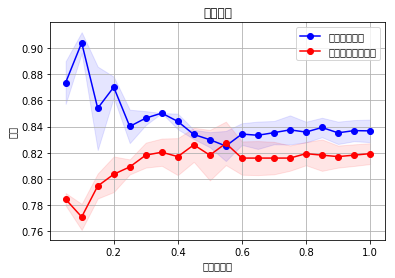

(0.82832629711477213, 0.033916495041812267)

In [9]:
#learning curve
from sklearn.model_selection import learning_curve

def plot_learning_curv(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,
                      train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    
    train_size, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    
    print(train_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"训练样本数")
        plt.ylabel(u"得分")
        #plt.gca().invert_yaxis()
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"训练集上得分")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"交叉验证集上得分")

        plt.legend(loc="best")

        plt.draw()
        plt.show()
        #plt.gca().invert_yaxis()

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

plot_learning_curv(clf, u"学习曲线", X, y, cv=3)

In [ ]:
array([ 0.84357542,  0.82681564,  0.79775281,  0.82022472,  0.86440678])
array([ 0.84357542,  0.82681564,  0.80337079,  0.82022472,  0.85875706])
array([ 0.84357542,  0.82681564,  0.80337079,  0.82022472,  0.86440678])
array([ 0.84357542,  0.82681564,  0.79213483,  0.82022472,  0.8700565 ])
array([ 0.84357542,  0.82681564,  0.79775281,  0.82022472,  0.8700565 ])
array([ 0.83798883,  0.82122905,  0.80337079,  0.80898876,  0.85875706])
array([ 0.82681564,  0.82122905,  0.80337079,  0.82022472,  0.84745763])
array([ 0.82122905,  0.83240223,  0.80898876,  0.82022472,  0.85875706])

In [ ]:
(0.8300484563793622, 0.026200211330200784)
(0.82635563492473763, 0.029975170661743378)
(0.8277815560181796, 0.032384678532457745)
(0.82983424696027397, 0.031117967991048157)
(0.82889637833395269, 0.028322650746166689)
(0.82783509714923031, 0.021773492869937239)
(0.82832629711477213, 0.033916495041812267)
(0.82762950397022739, 0.033448266691403994)

In [10]:
clf.fit(X,y)
predictions = clf.predict(test_df_clean.drop(columns='Survived'))

result = pd.DataFrame({'PassengerId':PassengerId.values, 'Survived':predictions.astype(np.int32)})
result.to_csv("./my_predictions.csv", index=False)

In [13]:
#划分训练集和交叉验证集
from sklearn import model_selection

split_train, split_cv = model_selection.train_test_split(train_df_clean, test_size=0.3, random_state=5)

X = split_train.drop(columns='Survived').values
y = split_train.Survived.values

X_cv = split_cv.drop(columns='Survived').values
y_cv = split_cv.Survived.values

In [43]:
#手动分析bad cases

from sklearn import linear_model
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)

clf.fit(X,y)
predictions = clf.predict(X_cv)

from sklearn import metrics
print("accuracy:", metrics.accuracy_score(y_cv, predictions, normalize=True, sample_weight=None))
print("recall:", metrics.recall_score(y_cv, predictions, labels=None, pos_label=1, average='binary', sample_weight=None))
print("precision:", metrics.precision_score(y_cv, predictions, labels=None, pos_label=1, average='binary', sample_weight=None))#origin_data_train = pd.read_csv("/Users/HanXiaoyang/Titanic_data/Train.csv")
#pd.DataFrame({'columns':list(train_df_clean.drop(columns='Survived').columns), 'coef':list(clf.coef_.T)})

accuracy: 0.835820895522
recall: 0.70297029703
precision: 0.835294117647


In [45]:
#bad cases
bad_cases_index = y_cv != predictions
good_cases_index = y_cv == predictions
bad_cases = train_df.iloc[split_cv[bad_cases_index].index]
good_cases = train_df.iloc[split_cv[good_cases_index].index]
bad_cases.insert(0, 'predict', 'WRONG')
good_cases.insert(0, 'predict', 'ACCEPT')
cases_org = pd.concat([bad_cases, good_cases], axis=0)

bad_cases2 = split_cv[bad_cases_index]
good_cases2 = split_cv[good_cases_index]
bad_cases2.insert(0, 'predict', 'WRONG')
good_cases2.insert(0, 'predict', 'ACCEPT')
cases_clean = pd.concat([bad_cases2, good_cases2], axis=0)

#bad_cases

In [ ]:
print(cases_org.columns)
print(cases_clean.columns)
print('-'*10)
ans1 = pd.crosstab(cases_org.predict, cases_org.Sex, margins=True)
ans1.apply(lambda x: x/ans1.All)

In [48]:
ans2 = pd.crosstab(cases_clean.predict, cases_clean['title__Master'], margins=True)
print(ans2)
ans2.apply(lambda x: x/ans2.All)

title__Master    0   1  All
predict                    
ACCEPT         212  12  224
WRONG           41   3   44
All            253  15  268


title__Master,0,1,All
predict,,,
ACCEPT,0.946429,0.053571,1.0
WRONG,0.931818,0.068182,1.0
All,0.944030,0.055970,1.0


In [49]:
#bad case analysis

#split_train.corr().Survived.sort_values(ascending=False)

array([ 0.83798883,  0.81005587,  0.79775281,  0.80337079,  0.85875706])

In [65]:
from sklearn.ensemble import BaggingRegressor

# fit到BaggingRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
bagging_clf = BaggingRegressor(clf, n_estimators=20, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(X, y)

predictions = bagging_clf.predict(test_df_clean.drop(columns='Survived'))
result2 = pd.DataFrame({'PassengerId':PassengerId.values, 'Survived':predictions.astype(np.int32)})
result2.to_csv("./my_bagging_predictions2.csv", index=False)

In [66]:
ans = pd.read_csv('./0836.csv')
ans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
PassengerId    418 non-null int64
Survived       418 non-null int64
dtypes: int64(2)
memory usage: 6.6 KB


In [67]:
print("norm:", (ans.Survived == result.Survived).sum())
print("bag:", (ans.Survived == result2.Survived).sum())


norm: 373
bag: 403


In [27]:
train_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 28 columns):
Survived                 891 non-null float64
SibSp                    891 non-null int64
Parch                    891 non-null int64
Fare                     891 non-null float64
title__Master            891 non-null uint8
title__Miss              891 non-null uint8
title__Mr                891 non-null uint8
title__Mrs               891 non-null uint8
title__Officer           891 non-null uint8
title__Royalty           891 non-null uint8
Age__(0.0902, 16.136]    891 non-null uint8
Age__(16.136, 32.102]    891 non-null uint8
Age__(32.102, 48.068]    891 non-null uint8
Age__(48.068, 64.034]    891 non-null uint8
Age__(64.034, 80.0]      891 non-null uint8
family                   891 non-null float64
Pclass_1                 891 non-null uint8
Pclass_2                 891 non-null uint8
Pclass_3                 891 non-null uint8
Sex_female               891 non-null uint8
Sex_male 

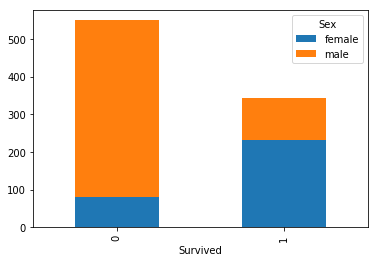

In [28]:
pd.crosstab(train_df.Survived, train_df.Sex).plot.bar(stacked=True)

In [70]:
a = train_df.copy()
a.loc[a.Cabin.notnull(), 'Cabin'] = a[a.Cabin.notnull()].Cabin.apply(lambda x: x[0])
#a.loc[a[a.Cabin.notnull()].Cabin > 'G', 'Cabin'] = 'T'
a.loc[a.Cabin > 'G', 'Cabin'] = 'T'

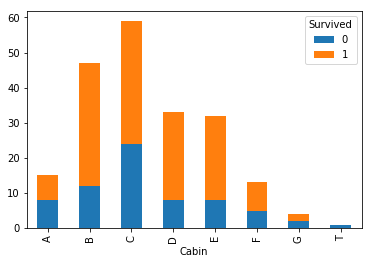

In [49]:
pd.crosstab(a.Cabin, a.Survived,).plot.bar(stacked=True)

In [56]:
test_df[test_df.Cabin.notnull()].Cabin.apply(lambda x: x[0]).value_counts()

C    35
B    18
D    13
E     9
F     8
A     7
G     1
Name: Cabin, dtype: int64